Importation des library

In [22]:
import pandas as pd
import numpy as np
import vectorbt as vbt
import matplotlib.pyplot as plt
import anywidget
import os

Chargement des données

In [23]:
# Télécharger les données (Utilise Python Binance)
# a PARTIR D'une date jusqu'a aujourd'hui (intervale 15 minutes)
symbol = ['ETHUSDT']
time = '15m'
# Téléchargement des données
data = vbt.BinanceData.download(
    symbol, 
    start='2024-09-01', 
    interval=time
)

0it [00:00, ?it/s]

Mise en forme des données

In [24]:
# Agencement des données + index + mis à l'heure de paris
df_raw = data.get(['Close','Open','High','Low','Volume']).copy()
df_raw.index = df_raw.index.tz_convert('Europe/Paris')
df_raw.tail()

,Close,Open,High,Low,Volume
Open time,,,,,
2025-12-06 23:30:00+01:00,3044.43,3044.57,3046.95,3042.60,543.0499
2025-12-06 23:45:00+01:00,3042.04,3044.42,3046.94,3041.66,494.2957
2025-12-07 00:00:00+01:00,3037.35,3042.05,3043.88,3032.81,1888.0767
2025-12-07 00:15:00+01:00,3030.36,3037.35,3039.26,3026.16,1910.6546
2025-12-07 00:30:00+01:00,3033.10,3030.36,3033.95,3029.01,697.5874


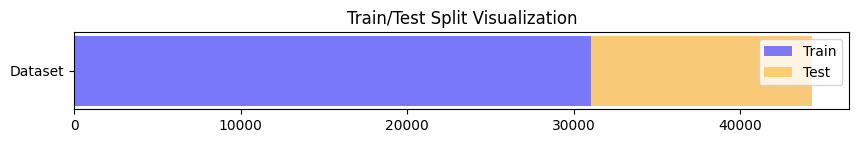

In [25]:
# Separation des données en train et test (IS/OOS) (70/30%)
split_idx = int(0.7*len(df_raw))
train_data = df_raw.iloc[:split_idx]
test_data = df_raw.iloc[split_idx:]

# Affichage de la séparation des données
plt.figure(figsize=(10, 1))
plt.barh(['Dataset'], [len(df_raw)], color='lightgray', alpha=0.3)
plt.barh(['Dataset'], [split_idx], color='blue', alpha=0.5, label='Train')
plt.barh(['Dataset'], [len(df_raw)-split_idx], left=split_idx, color='orange', alpha=0.5, label='Test')
plt.title('Train/Test Split Visualization')
plt.legend()
plt.show()

In [30]:
# Selection du train_set comme données d'entrainement
df = train_data.copy()

**La stratégie**

Voici une stratégie simple de croisement de moyennes mobiles adaptée au 15 minutes :

Entrée Long : Quand la moyenne mobile 9 croise au-dessus de la moyenne mobile 21.
Sortie : Croisement inverse ou stop loss 2%.

In [33]:
fast_window = 9
slow_window = 21

# Calcul des moyennes mobiles
df['ma_fast'] = df['Close'].rolling(window=fast_window).mean()
df['ma_slow'] = df['Close'].rolling(window=slow_window).mean()

# Signaux d'entrée et de sortie
entries = (df['ma_fast'] > df['ma_slow']) & (df['ma_fast'].shift(1) <= df['ma_slow'].shift(1))
exits = (df['ma_fast'] < df['ma_slow']) & (df['ma_fast'].shift(1) >= df['ma_slow'].shift(1))

**Backtest**

In [38]:
for fast_window in range(5, 21, 2):      # ex: 5, 7, 9, ..., 19
    for slow_window in range(fast_window+2, 31, 2):  # slow > fast
        df['ma_fast'] = df['Close'].rolling(window=fast_window).mean()
        df['ma_slow'] = df['Close'].rolling(window=slow_window).mean()
        entries = (df['ma_fast'] > df['ma_slow']) & (df['ma_fast'].shift(1) <= df['ma_slow'].shift(1))
        exits = (df['ma_fast'] < df['ma_slow']) & (df['ma_fast'].shift(1) >= df['ma_slow'].shift(1))

        portfolio = vbt.Portfolio.from_signals(
            close=df['Close'],
            entries=entries,
            exits=exits,
            size_type='percent',
            init_cash=50,
            size=0.6,
            sl_stop=0.02,  # Stop loss 2%
            fees=0.001,
            slippage=0.001,
            freq=time
        )

        stats = portfolio.stats()
        # Affichage des statistiques
        print(portfolio.stats())
        # ajout des statistique dans un csv (les ajouter a la suite et ne pas écraser les données existantes)
        stats = portfolio.stats().to_frame().T
        stats['fast_window'] = fast_window
        stats['slow_window'] = slow_window
        stats.to_csv('backtest_stats.csv', mode='a',header=not os.path.exists('backtest_stats.csv'),index=False,)


# Tracer la valeur du portefeuille
#portfolio.plot(width=1000, height=1000).show()

# Afficher les Trades
#fig = portfolio.trades.plot()
#fig.update_layout(width=1200, height=600)
#fig.show()

Start                         2024-09-01 01:00:00+02:00
End                           2025-07-21 10:45:00+02:00
Period                                323 days 10:00:00
Start Value                                        50.0
End Value                                       0.07232
Total Return [%]                              -99.85536
Benchmark Return [%]                          50.315549
Max Gross Exposure [%]                        62.551287
Total Fees Paid                               25.037568
Max Drawdown [%]                               99.85536
Max Drawdown Duration                 323 days 05:30:00
Total Trades                                       2879
Total Closed Trades                                2879
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                  18.200764
Best Trade [%]                                 9.549393
Worst Trade [%]                               -5